In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os, glob
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # GPU
import tensorflow.python as tf

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from scipy import signal, ndimage
from scipy.io import loadmat, savemat
from skimage import data, img_as_float, exposure
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

In [2]:
def uniform_circle(x0, y0, sigma, width, height):
    x = np.arange(0, width, 1, float)
    y = np.arange(0, height, 1, float)[:, np.newaxis]
    tmp = (x - x0)**2 + (y - y0)**2 < sigma ** 2
    return tmp.astype(int)

In [3]:
def get_y_as_heatmap_u(y, width, height, sigma=3):
    ymap = []
    for i in range(y.shape[0]):
        msk_array = np.zeros((width, height, 15), dtype=np.float32)
        for j in range(15):
            msk = uniform_circle(y[i, 2*j]*width, y[i, 2*j+1]*height, sigma, width, height)
            msk_array[:,:,j] = msk
        ymap.append(msk_array)
    ymap = np.array(ymap)
    return ymap

In [4]:
def gaussian_k(x0, y0, sigma, width, height):
    x = np.arange(0, width, 1, float)
    y = np.arange(0, height, 1, float)[:, np.newaxis]
    return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))

def get_y_as_heatmap_k(y, width, height, sigma=3):
    ymap = []
    for i in range(y.shape[0]):
        msk_array = np.zeros((width, height, 15), dtype=np.float32)
        for j in range(15):
            msk = gaussian_k(y[i, 2*j]*width, y[i, 2*j+1]*height, sigma, width, height)
            msk_array[:,:,j] = msk
        ymap.append(msk_array)
    ymap = np.array(ymap)
    return ymap

In [5]:
from func_processing import img_affine, img_hflip, load, get_avg_xy
from sklearn.model_selection import train_test_split

FTRAIN = './data/facial-keypoints-detection/training/training.csv'

In [6]:
# load data
X, Y = load(FTRAIN)
X = X.reshape(-1,96,96)
# split into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

In [7]:
# training data augmentation
np.random.seed(0)
dz = np.random.randint(-5,5,(X_train.shape[0],2))
X_train0 = []
Y_train0 = []
for i, x in enumerate(X_train):
    xt, yt = img_affine(np.squeeze(x), Y_train[i], dz[i,0], dz[i,1], 96, 96)
    X_train0.append(xt)
    Y_train0.append(yt)
    xf, yf = img_hflip(np.squeeze(x), Y_train[i])
    X_train0.append(xf)
    Y_train0.append(yf)
X_train0 = np.array(X_train0)
Y_train0 = np.array(Y_train0)

In [8]:
X_train0 = np.expand_dims(X_train0, axis=3)

In [9]:
import tensorflow.python.keras.backend as K 
def dice_coef(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def area_coef(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    return K.minimum(y_true_f, y_pred_f) / (K.maximum(y_true_f, y_pred_f) + smooth)
def soft_dice_mse(y_true, y_pred):
    dice = 1 - dice_coef(y_true, y_pred)
    mse = tf.keras.losses.MeanSquaredError()
    # mse = tf.keras.losses.MSE(y_true, y_pred)
    return dice + mse(y_true, y_pred)
def custom_loss(y_true, y_pred):
    dice = 1 - dice_coef(y_true, y_pred)
    area = 1 - area_coef(y_true, y_pred)
    mse = tf.keras.losses.MeanSquaredError()
    # mse = tf.keras.losses.MSE(y_true, y_pred)
    return dice + area + mse(y_true, y_pred)

In [10]:
from func_UNET import unet
sigma = 5
y_train0 = get_y_as_heatmap_k(Y_train0, 96, 96, sigma)
X_train, X_valid, y_train, y_valid = train_test_split(X_train0, y_train0, test_size=0.2, random_state=43)

model = unet(96, 96, 1, DROPOUT=0.5, NFILTER=16)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
# EarlyStopping(patience=10, verbose=1),
ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
ModelCheckpoint('model-tgs-seg2.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

history = model.fit(X_train, y_train, batch_size=32, epochs=200, callbacks=callbacks, validation_data=(X_valid, y_valid))

ve from 0.00177
3081/3081 [==============================] - 5s 2ms/sample - loss: 0.0020 - acc: 0.4333 - val_loss: 0.0018 - val_acc: 0.4749
Epoch 131/200
3040/3081 [============================>.] - ETA: 0s - loss: 0.0020 - acc: 0.4330
Epoch 00131: val_loss improved from 0.00177 to 0.00177, saving model to model-tgs-seg2.h5
3081/3081 [==============================] - 5s 2ms/sample - loss: 0.0020 - acc: 0.4332 - val_loss: 0.0018 - val_acc: 0.4754
Epoch 132/200
3040/3081 [============================>.] - ETA: 0s - loss: 0.0019 - acc: 0.4348
Epoch 00132: val_loss improved from 0.00177 to 0.00177, saving model to model-tgs-seg2.h5
3081/3081 [==============================] - 5s 2ms/sample - loss: 0.0019 - acc: 0.4344 - val_loss: 0.0018 - val_acc: 0.4764
Epoch 133/200
3040/3081 [============================>.] - ETA: 0s - loss: 0.0020 - acc: 0.4336
Epoch 00133: val_loss did not improve from 0.00177
3081/3081 [==============================] - 5s 2ms/sample - loss: 0.0020 - acc: 0.4337 - 

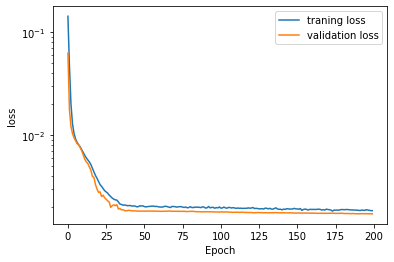

In [11]:
plt.plot(history.history['loss'], label='traning loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.yscale('log')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')
# plt.show()
plt.savefig('hist_unet.png')

In [12]:
model_predict = model.predict(X_test)
y_pred = np.zeros((model_predict.shape[0], 30))
for i in range(model_predict.shape[0]):
    for j in range(15):
        msk = np.squeeze(model_predict[i,:,:,j])
        yx, prob = get_avg_xy(msk, 25)
        y_pred[i,2*j] = yx[1] / 96
        y_pred[i,2*j+1] = yx[0] / 96
error = np.linalg.norm(Y_test - y_pred)

print(error)

16.187713188428216


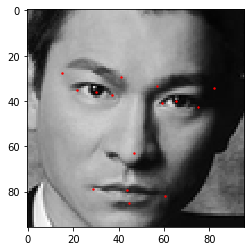

In [13]:
j = 20
plt.imshow(np.squeeze(X_test[j]), cmap='gray')
for i in range(15):
    plt.scatter(y_pred[j, 2*i]*96, y_pred[j, 2*i+1]*96, s=2, c='r')
plt.show()

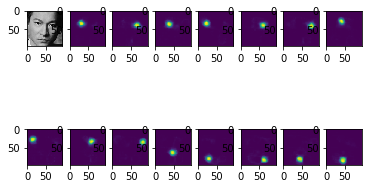

In [14]:
plt.subplot(2,8,1)
plt.imshow(np.squeeze(X_test[j]), cmap='gray')
for i in range(15):
    plt.subplot(2,8,i+2)
    plt.imshow(np.squeeze(model_predict[j,:,:,i]))
plt.show()

In [15]:
model.save('./model/unet_k')